# Solve 1D Laplace's equation 

## Import packages

In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from neal import SimulatedAnnealingSampler
from dwave.system import EmbeddingComposite, DWaveSampler

from dwaveutils import bl_lstsq
from dwaveutils.utils import Binary2Float

## Define function

In [2]:
def get_linear_system(N, num_bits,
                   fixed_point=0, exact_x=True, random_seed=None):
    """Get information about 1D Laplace's equation."""

    # number of predictor and number of response
    num_predictor_discrete = num_bits * N
    num_response = N

    # matrix `A`
    A = (np.eye(num_response, k=-1)
         - 2 * np.eye(num_response, k=0)
         + np.eye(num_response, k=1))
    # set the bit value to discrete the actual value as a fixed point
    bit_value = bl_lstsq.get_bit_value(num_bits, fixed_point=fixed_point)
    # discretized version of matrix `A`
    A_discrete = bl_lstsq.discretize_matrix(A, bit_value)

    if random_seed is None:
        rng = np.random.default_rng()
    else:
        rng = np.random.default_rng(random_seed)

    if exact_x:
        # binary vector `q`
        q = rng.choice([0, 1], size=num_predictor_discrete)
        # vector `x`
        x = q2x(q, bit_value)
    else:
        # vector `x`
        x = (rng.choice([-1, 1], size=num_response)
             * (2 ** fixed_point) * rng.random(num_response))

    # calculate vector `b`
    b = A @ x

    output = {
        'A': A,
        'x': x,
        'b': b,
        'A_discrete': A_discrete,
        'bit_value': bit_value
    }
    return output

## Setting variables

In [3]:
# size of symmetric matrix `A`
N = 3
# number of bits (include sign bit)
num_bits = 4
# n-vector bit value is defined by
# [-2**(fixed_point), 2**(fixed_point-1), ..., 2**(fixed_point-n)]
fixed_point = 0
# whether x can be perfectly discrete
exact_x = False
random_seed = 19937
# scaling factor for QUBO
eq_scaling_val = 1/8
# number of reads for Simulated annealing (SA) or Quantum annealing (QA)
num_reads = 1000
# sampler type must be one of {'SA', 'QA'}
sampler_type = 'SA'

# setup A, x, b, A_discrete, bit_value
output = get_linear_system(
    N, num_bits,
    fixed_point=fixed_point, exact_x=exact_x, random_seed=random_seed
)
A = output['A']
true_x = output['x']
true_b = output['b']
A_discrete = output['A_discrete']
bit_value = output['bit_value']

## Solve A*x=b by `numpy.linalg.lstsq`

In [4]:
np_x = np.linalg.lstsq(A, true_b, rcond=None)[0]

## Solve A_discrete*q=b problem as BQM optimization through simulated annealing or quantum annealing

In [5]:
Q = bl_lstsq.get_qubo(A_discrete, true_b, eq_scaling_val=eq_scaling_val)
if sampler_type == 'QA':
    try:
        sampler = EmbeddingComposite(DWaveSampler(solver={'qpu': True}))
        _sampler_args = {}
        if 'num_reads' in sampler.parameters:
            _sampler_args['num_reads'] = num_reads
        if 'answer_mode' in sampler.parameters:
            _sampler_args['answer_mode'] = 'raw'
        sampleset = sampler.sample_qubo(Q, **_sampler_args)
    except ValueError:
        warnings.warn('Cannot access QPU, use \
                        SimulatedAnnealingSampler instead.')
        sampler = SimulatedAnnealingSampler()
        sampleset = sampler.sample_qubo(Q, num_reads=num_reads)
elif sampler_type == 'SA':
    sampler = SimulatedAnnealingSampler()
    sampleset = sampler.sample_qubo(Q, num_reads=num_reads)
else:
    raise(ValueError("The sampler_type is wrong, \
                        please enter 'SA' or 'QA'"))

## Solve A_discrete*q=b by brute force
`Warning: this may take a lot of time!`

In [6]:
best_q, best_x, min_norm = bl_lstsq.bruteforce(A_discrete, true_b, bit_value)

brute force: 100%|██████████| 4096/4096 [00:00<00:00, 53217.45it/s]


## Prepare for showing results and plotting

In [7]:
# convert sampleset and its aggregate version to dataframe
sampleset_pd = sampleset.to_pandas_dataframe()
sampleset_pd_agg = sampleset.aggregate().to_pandas_dataframe()
num_states = len(sampleset_pd_agg)
num_b_entry = len(true_b)
num_x_entry = len(true_x)
num_q_entry = A_discrete.shape[1]
# concatnate `sampleset_pd` and `x_at_each_read`
x_at_each_read = pd.DataFrame(
    np.row_stack(
        [(sampleset_pd.iloc[i][:num_q_entry]).values.reshape(
            (num_x_entry, -1)) @ bit_value
            for i in range(num_reads)]
    ),
    columns=['x' + str(i) for i in range(num_x_entry)]
)
sampleset_pd = pd.concat([sampleset_pd, x_at_each_read], axis=1)
sampleset_pd.rename(
    columns=lambda c: c if isinstance(c, str) else 'q'+str(c),
    inplace=True
)
# concatnate `sampleset_pd_agg` and `x_at_each_state`
x_at_each_state = pd.DataFrame(
    np.row_stack(
        [(sampleset_pd_agg.iloc[i][:num_q_entry]).values.reshape(
            (num_x_entry, -1)) @ bit_value
            for i in range(num_states)]
    ),
    columns=['x' + str(i) for i in range(num_x_entry)]
)
sampleset_pd_agg = pd.concat([sampleset_pd_agg, x_at_each_state], axis=1)
sampleset_pd_agg.rename(
    columns=lambda c: c if isinstance(c, str) else 'q'+str(c),
    inplace=True
)
# lowest energy state x and q
lowest_q = sampleset_pd_agg.sort_values(
    'energy').iloc[0, :num_q_entry].values
lowest_x = Binary2Float.to_fixed_point(lowest_q, bit_value)
# frequently occurring x and q
frequent_q = sampleset_pd_agg.sort_values(
    'num_occurrences', ascending=False).iloc[0, :num_q_entry].values
frequent_x = Binary2Float.to_fixed_point(frequent_q, bit_value)
# calculate expected x from x
expected_x = sampleset_pd_agg.apply(
    lambda row: row.iloc[-num_x_entry:]
    * (row.num_occurrences / num_reads),
    axis=1
).sum().values
# calculate excepted x from q
tmp_q = sampleset_pd_agg.apply(
    lambda row: row.iloc[:num_q_entry]
    * (row.num_occurrences / num_reads),
    axis=1
).sum() > 0.5  # bool
expected_x_discrete = Binary2Float.to_fixed_point(np.array(tmp_q), bit_value)

## Show results

In [8]:
print('='*50)
print('true x:', true_x)
print('true b:', true_b)
print('bit value:', bit_value)

print('='*50)
print('# numpy solver')
print('np_x: ', np_x)
print('b:', A @ np_x)
print('2-norm:', np.linalg.norm(A @ np_x - true_b))

print('='*50)
print('# brute force')
print('best x:', best_x)
print('best q:', best_q)
print('b:', A @ best_x)
print('2-norm:', min_norm)

print('='*50)
print('# Simulated annealing/Quantum annealing')
print('lowest energy state x:')
print(lowest_x)
print('lowest energy state q:')
print(lowest_q)
print('b:', A @ lowest_x)
print('2-norm:', np.linalg.norm(A @ lowest_x - true_b))
print('-'*50)
print('most frequently occurring x:')
print(frequent_x)
print('most frequently occurring q:')
print(frequent_q)
print('b:', A @ frequent_x)
print('2-norm:', np.linalg.norm(A @ frequent_x - true_b))
print('-'*50)
print('expected x (from real value):')
print(expected_x)
print('b:', A @ expected_x)
print('2-norm:', np.linalg.norm(A @ expected_x - true_b))
print('-'*50)
print('expected x (from discrete value):')
print(expected_x_discrete)
print('b:', A @ expected_x_discrete)
print('2-norm:', np.linalg.norm(A @ expected_x_discrete - true_b))
print('-'*50)
print('Sample set:')
print(sampleset_pd_agg.sort_values('num_occurrences', ascending=False))
print('='*50)

true x: [-0.51854756 -0.17133454 -0.29798686]
true b: [ 0.86576058 -0.47386534  0.42463918]
bit value: [-1.     0.5    0.25   0.125]
# numpy solver
np_x:  [-0.51854756 -0.17133454 -0.29798686]
b: [ 0.86576058 -0.47386534  0.42463918]
2-norm: 5.926969055564841e-16
# brute force
best x: [-0.5   -0.125 -0.25 ]
best q: [1 1 0 0 1 1 1 1 1 1 1 0]
b: [ 0.875 -0.5    0.375]
2-norm: 0.05685451454693682
# Simulated annealing/Quantum annealing
lowest energy state x:
[-0.5   -0.125 -0.25 ]
lowest energy state q:
[1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0.]
b: [ 0.875 -0.5    0.375]
2-norm: 0.05685451454693682
--------------------------------------------------
most frequently occurring x:
[-0.5   -0.125 -0.25 ]
most frequently occurring q:
[1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0.]
b: [ 0.875 -0.5    0.375]
2-norm: 0.05685451454693682
--------------------------------------------------
expected x (from real value):
[-0.446625 -0.07525  -0.238125]
b: [ 0.818   -0.53425  0.401  ]
2-norm: 0.08053689563646313
-----

## Plot histogram

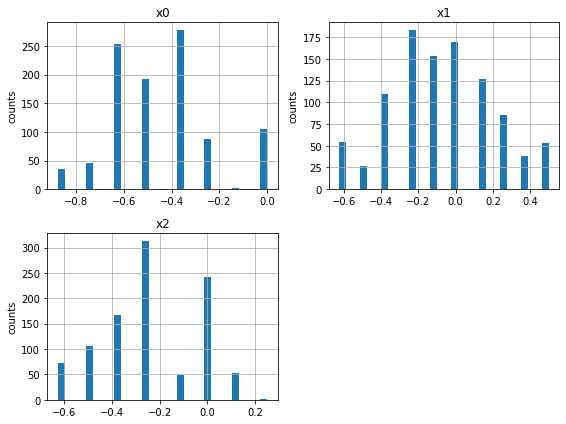

In [9]:
axes = sampleset_pd.hist(
    figsize=(8, 6), bins=30,
    column=['x' + str(i) for i in range(num_x_entry)],
)
axes = axes.ravel()
for i in range(num_x_entry):
    ax = axes[i]
    ax.set_ylabel('counts')
plt.tight_layout()
plt.show()